In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim 
import normflows as nf
device='cuda'

In [2]:
import torch.nn.functional as F

class ConditionalLinear(nn.Module):
    def __init__(self, num_in, num_out, num_classes):
        super().__init__()
        self.num_out = num_out
        self.lin = nn.Linear(num_in, num_out)
        self.embed = nn.Embedding(num_classes, num_out)
        self.embed.weight.data.uniform_()

    def forward(self, x, y):
        out = self.lin(x)
        gamma = self.embed(y)
        out = gamma.view(-1, self.num_out) * out
        return out
    
class ConditionalModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.lin1 = ConditionalLinear(2, 128, num_classes)
        self.lin2 = ConditionalLinear(128, 128, num_classes)
        self.lin3 = nn.Linear(128, 2)
    
    def forward(self, x, y):
        x = F.softplus(self.lin1(x, y))
        x = F.softplus(self.lin2(x, y))
        return self.lin3(x)

In [3]:
def anneal_dsm_score_estimation(model, samples, labels, sigmas, anneal_power=2.):
    used_sigmas = sigmas[labels].view(samples.shape[0], *([1] * len(samples.shape[1:])))
    perturbed_samples = samples + torch.randn_like(samples) * used_sigmas
    target = - 1 / (used_sigmas ** 2) * (perturbed_samples - samples)
    scores = model(perturbed_samples, labels)
    target = target.view(target.shape[0], -1)
    scores = scores.view(scores.shape[0], -1)
    loss = 1 / 2. * ((scores - target) ** 2).sum(dim=-1) * used_sigmas.squeeze() ** anneal_power
    return loss.mean(dim=0)

## Sampling with annealed Langevin dynamic

$$\tilde{x}_{t} = \tilde{x}_{t-1}+\frac{\alpha_{i}}{2}\nabla_{\tilde{x}_{t-1}}{\log}p_{\sigma_{i}}(\tilde{x}_{t-1})+\sqrt{\alpha_{i}}z_{t}\ \ \text{where, } i\in [1, L]\ \  \text{and}\ \  t\in[1,T]$$

In [4]:
import torch
import math


def annealed_langevin_dynamic(sigma_min, sigma_max, n_steps, annealed_step, score_fn,init_point, device, eps=1e-1, only_final=False):
    process = torch.exp(torch.linspace(start=math.log(
        sigma_max), end=math.log(sigma_min), steps=n_steps)).to(device=device)
    step_size = eps * (process / process[-1]) ** 2

    sample = init_point
    sampling_list = []

    final = None
    score_fn.eval()
    for idx in range(len(process)):
        labels = torch.ones(init_point.shape[0], dtype=torch.long).to(device=device) * idx
        for _ in range(annealed_step):
            z, step = torch.randn_like(sample).to(
                device=device), step_size[idx]
            with torch.no_grad():
                sample = sample + 0.5 * step * \
                    score_fn(sample, labels) + torch.sqrt(step) * z

        final = sample
        if not only_final:
            sampling_list.append(final)

    return final if only_final else torch.stack(sampling_list)

In [5]:
# from sklearn.datasets import make_swiss_roll
# def sample_batch(size, noise=1.0):
#     x, _= make_swiss_roll(size, noise=noise)
#     return x[:, [0, 2]] / 10.0
# # Plot it
# data = sample_batch(10**5)
target = nf.distributions.CircularGaussianMixture()
data = target.sample(100000)

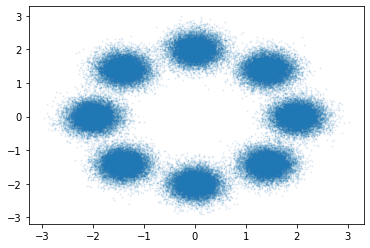

In [6]:
plt.scatter(data.numpy()[:,0], data.numpy()[:,1], s=1, alpha=0.1)

In [7]:
#parameters for perturbation
sigma_min = 0.01
sigma_max = 1
num_levels= 4

device = torch.device('cuda')

sigmas = torch.tensor(np.exp(np.linspace(np.log(sigma_max), np.log(sigma_min), num_levels))).float().to(device)


In [8]:
batch_size = 10000
from torch.utils.data import TensorDataset
dataset=TensorDataset(data)
dataloader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, drop_last = True)
# dataloader for data
# dataiterator = iter(dataloader)

In [9]:
# Our approximation model
model = ConditionalModel(num_levels).to(device)
# Create ADAM optimizer over our model
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [10]:
epochs=5000
batch = torch.tensor(data, dtype=torch.float32).to(device)
for epoch in range(epochs):
    # for batch in dataloader:

        # batch = batch[0].to(device)
        
    labels = torch.randint(0, len(sigmas), (batch.shape[0],)).to(device)
    loss = anneal_dsm_score_estimation(model, batch, labels, sigmas)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    if ((epoch % 1000) == 0):
        print(loss.item())

/tmp/ipykernel_1969672/3948430227.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = torch.tensor(data, dtype=torch.float32).to(device)


1.0342801809310913
0.8074544072151184
0.8049418330192566
0.7971580028533936
0.8011506199836731


(-3.0, 3.0)

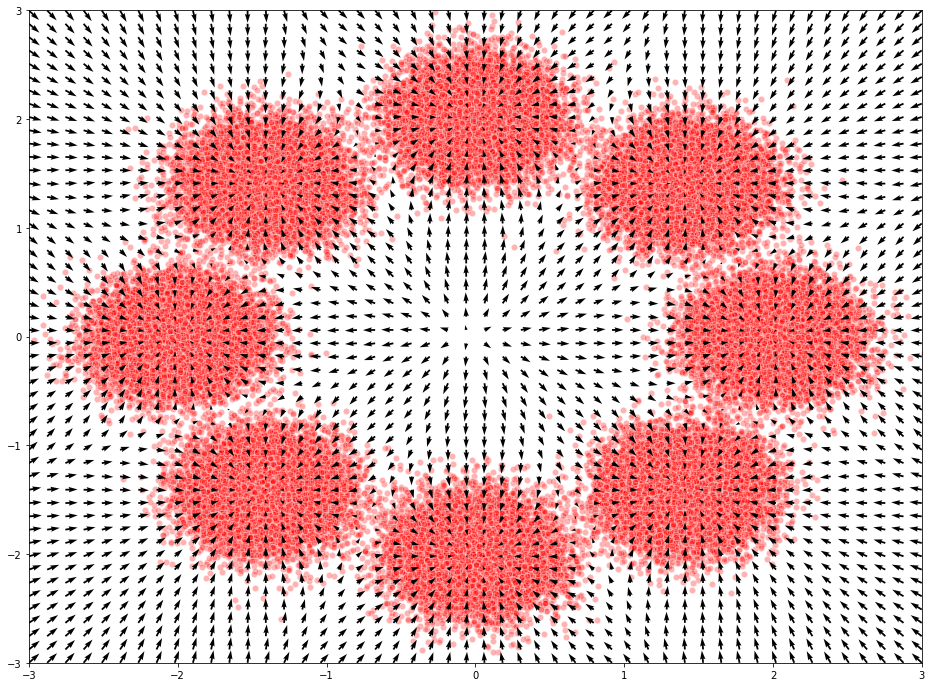

In [11]:
xx = np.stack(np.meshgrid(np.linspace(-3, 3.0, 50), np.linspace(-3, 3.0, 50)), axis=-1).reshape(-1, 2)
# xx = np.stack(np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50)), axis=-1).reshape(-1, 2)
labels = torch.ones(xx.shape[0]).long().to(device)*2
scores = model(torch.tensor(xx).float().to(device), labels).detach().cpu().numpy()
scores_norm = np.linalg.norm(scores, axis=-1, ord=2, keepdims=True)
scores_log1p = scores / (scores_norm + 1e-9) * np.log1p(scores_norm)
# Perform the plots
plt.figure(figsize=(16,12))
plt.scatter(*data.T, alpha=0.3, color='red', edgecolor='white', s=40)
plt.quiver(*xx.T, *scores_log1p.T, width=0.002, color='black')
plt.xlim(-3, 3)
plt.ylim(-3, 3)

# plt.xlim(-5, 5)
# plt.ylim(-5, 5)

In [12]:
# parameters for sampling

eps = 1e-5
n_steps = num_levels
annealed_step = 10000
sampling_number = 10000
only_final = False

init_point=torch.randn(sampling_number,2).to(device)*3.5-1.5


dynamic = annealed_langevin_dynamic(
    sigma_min, sigma_max, n_steps, annealed_step, model,init_point, device, eps,only_final)

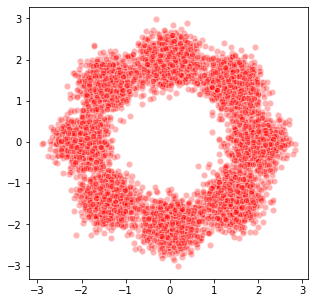

In [20]:

plt.figure(figsize=(5,5))
plt.scatter(*dynamic[3].cpu().numpy().T , alpha=0.3, color='red', edgecolor='white', s=40)

In [16]:
true_samples=data.numpy()
sm_samples=dynamic[-1].cpu().numpy()

In [19]:

from scipy.stats import ks_2samp

ks_2samp(true_samples[:,0],sm_samples[:,0]),ks_2samp(true_samples[:,0],sm_samples[:,0])

(KstestResult(statistic=0.05064999999999997, pvalue=1.0419112215771406e-20),
 KstestResult(statistic=0.05064999999999997, pvalue=1.0419112215771406e-20))